# OOP Version

## Define Functions

In [25]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import folium
import json
import matplotlib.pyplot as plt
import seaborn as sns

### Web Scraping housing information

In [48]:
# scrape listing info
def get_housings(url): 
    housings_list = list()
    import requests
    from bs4 import BeautifulSoup
    # Request for home page of NY housing info
    try:
        results_page = requests.get(url)
    except:
        return None
    try:
        soup = BeautifulSoup(results_page.content,'lxml')
    except:
        return None
    # Get all the feature housings and bold housings on the first page
    feature_housings = soup.find_all('article',class_='panel-listing-result listing-featured ')
    for housing in feature_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
            housings_list.append([detail_dict,link])
    # Second Type of housing
    all_housings = soup.find_all('article', class_='panel-listing-result listing-bold ')
    for housing in all_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
            housings_list.append([detail_dict,link])
    # Third type of housing:
    early_bird_housings = soup.find_all('article', class_='panel-listing-result listing-free ')
    for housing in early_bird_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            detail_dict['Short_description'] = name
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
            housings_list.append([detail_dict,link])
#     Turn to next page and get more housings
    if soup.find('ul',class_='navnext'):
        if soup.find('ul',class_='navnext').find('a'):
            next_page_token = soup.find('ul',class_='navnext').find('a').get('href')
            next_page = 'https://www.spareroom.co.uk/flatshare/' + next_page_token
        # Use recursion to get all the attractions    
            housings_list.extend(get_housings(next_page))
    return housings_list

In [49]:
# scraping detailed info
def get_details(list_leeds):
    count = 0 
    full_dict = dict()
    for dict_info, link in list_leeds:
        import requests
        from bs4 import BeautifulSoup
        # Request for details of each housing in NY
        try:
            results_page = requests.get(link)
        except:
            continue
        try:
            soup = BeautifulSoup(results_page.content,'lxml')
        except:
            continue
        # Get housing price for each room 
        price_list = list()
        if soup.find('ul', class_='room-list'): 
            prices = soup.find('ul', class_='room-list')
            price = prices.find_all('strong', class_='room-list__price')
            for price_i in price:
                price_list.append(price_i.get_text())
        if not price_list:
            if soup.find('section', class_='feature feature--price-whole-property'):
                price = soup.find('h3', class_='feature__heading')
                price_list.append(price.get_text())
        # Clean the data to remove 'Availability' in the price list
        if 'Availability' in price_list:
            price_list.remove('Availability')
        dict_info['Price'] = price_list
        # Get Availability for each housing
        avail = soup.find('section', class_='feature feature--availability')
        if avail:
            all_info_avail = avail.find_all('dd', class_='feature-list__value')
            availablility = all_info_avail[0].get_text()      
            min_period = all_info_avail[1].get_text()      
            max_period = all_info_avail[2].get_text() 
            dict_info['Availablility'] = availablility
            dict_info['Min_period'] = min_period
            dict_info['Max_period'] = max_period
        # Get Amenities info for each housing
        amenities = soup.find('section', class_='feature feature--amenities')
        if amenities:
            all_info_amenities = amenities.find_all('dd', class_='feature-list__value')
            if all_info_amenities:
                furnish = all_info_amenities[0].get_text()
                dict_info['Furnishing'] = furnish
        else:
            dict_info['Furnishing'] = 'No info'
        # Female/Male requirement
        preference = soup.find('section', class_='feature feature--household-preferences')
        if preference:
            preference_info = preference.find_all('dt', class_='feature-list__key')
            preference_detail = preference.find_all('dd', class_='feature-list__value')
            if preference_info and preference_detail:
                for info in preference_info:
                    if info.get_text() == 'Gender':
                        info_index = preference_info.index(info)
                        break
                try:
                    gender = preference_detail[info_index].get_text() 
                    dict_info['Gender_requirement'] = gender
                except:
                    dict_info['Gender_requirement'] = 'No info'
        full_dict[count] = dict_info
        count = count + 1
#     return price_list
    return full_dict

### Data Clean

In [50]:
def clean(dict_):
    for key in dict_.keys():
        for subkey in dict_[key].keys():
            if isinstance(dict_[key][subkey], str):
                dict_[key][subkey] = dict_[key][subkey].lstrip().rstrip()
    # Clean the price list
    for key in dict_.keys():
        list_in = list()
        for item in list(dict_[key]['Price']):
            list_in.append(item.strip('\n'))
        dict_[key]['Price'] = list_in
        
    df_info = pd.DataFrame(dict_)
    df_info = df_info.T

    # Fix furnished problem
    for i in df_info.index:
        if df_info.iloc[i]['Furnishing'] in ['Furnished', 'Part Furnished', 'Unfurnished']:
            pass
        else:
            df_info.iloc[i]['Furnishing'] = 'No info'
    # Fix Gender_requirement problem
    for i in df_info.index:
        if df_info.iloc[i]['Gender_requirement'] in ['Males or females', 'Female preferred', 'No info','Male preferred']:
            pass
        else:
            df_info.iloc[i]['Gender_requirement'] = 'No info'
    # Create a new col in df_info to store average price for a single person
    pattern = r'\d+'  
    price_per_month = list()

    for i in df_info.index:
        list_in_price = list()
        for item in df_info.iloc[i]['Price']:
            item = item.replace(',', '')
            if 'pw' in item:
                price_info = int((re.findall(pattern, item))[0])
                list_in_price.append(price_info*4)
            if 'pcm' in item:
                price_info = int((re.findall(pattern, item))[0])
                list_in_price.append(price_info)
        price_per_month.append(list_in_price)
    price_per_month = np.array(price_per_month)
    df_info['Price_per_month'] = price_per_month
    list_avg_price = list()
    for i in df_info.index:
        list_avg_price.append(np.mean(df_info.iloc[i]['Price_per_month']) )
    df_info['Average_price_per_month'] = np.array(list_avg_price)
    # Create a new col in df_info to store zip code for each housing
    # Create a new col for zip code
    list_pos = list()
    for i in df_info.index:
        for s in df_info.iloc[i]['Location']:
            if s == '(':
                position = df_info.iloc[i]['Location'].index(s)
                break
        list_pos.append(df_info.iloc[i]['Location'][position:].strip('(').strip(')'))
    df_info['Postal_code'] = np.array(list_pos)
    return df_info

### Data Visualization

In [51]:
%matplotlib inline
plt.style.use('seaborn')

In [52]:
# input data should be df_info.groupy().size() 
def plot_bar(data, title, figsize=(6,4), sort = False):
    if sort:
        data.sort_values(ascending=False).plot(kind='bar', title=title, figsize = figsize)
    else:
        data.plot(kind='bar', title=title, figsize = figsize)

In [53]:
# input data should be df_info.groupy().size() 
def plot_pie(data, title, figsize=(6,4)):
    label = data.index
    fig1, ax1 = plt.subplots(figsize=figsize)
    ax1.pie(data, labels = label, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title, fontsize=15, fontweight='bold')
    plt.legend()
    plt.show()

In [63]:
def distplot(data,array):
    array = data['Average_price_per_month'].astype('int')
    sns.distplot(array)

In [55]:
def heatmap(df_info, location, kind):
    zip_groups = df_info.groupby('Postal_code')
    sizes = zip_groups.size()
    sizes = sizes.rename("size")
    avg_price = zip_groups.Average_price_per_month.mean()
    info_group_by_zip = pd.concat([sizes, avg_price], axis = 1)
    info_group_by_zip['zip'] = info_group_by_zip.index
    
    # read the geojson file and get all the postcode
    filename = location.lower() + '_postcodes.geojson'
    with open(filename,'r') as load_f: 
        geojson = json.load(load_f)

    # drop zip zone that we don't have data in geojson
    geojson['features'] = [item for item in geojson['features'] if item['properties']['Name'] in info_group_by_zip.index]
    
    # set each city's center location
    center = {}
    center['Manchester'] = [53.483959, -2.244644]
    center['London'] = [51.5074, 0.1278]
    center['Liverpool'] = [53.3, -3]
    center['Leeds'] = [53.8008, 1.5491]
    
    
    if kind == 'size':
        m = folium.Map(location = center[location], zoom_start=10) ####
        m.choropleth(geo_data=geojson, data=info_group_by_zip, 
                     columns=['zip','size'],
                     key_on='feature.properties.Name',
                     fill_color='YlGn', fill_opacity=0.7, line_opacity=0.8,
                     legend_name='the number of housings')
        folium.LayerControl().add_to(m)
        return m
    
    if kind == 'price':
        m = folium.Map(location = center[location], zoom_start=10) ###
        m.choropleth(geo_data=geojson, data=info_group_by_zip, 
                     columns=['zip','Average_price_per_month'],
                     key_on='feature.properties.Name',
                     fill_color='YlGn', fill_opacity=0.7, line_opacity=0.8,
                     legend_name='average housing price')
        return m

## Create a blueprint for all the four cities

In [68]:
class rental:
    def __init__(self, url, location):
        self.location = location
        self.url = url
        self.dict_ = get_details(get_housings(self.url))
    @property
    def df(self):
        return clean(self.dict_)

    # kind should be 'bar' or 'pie'
    def gender_preference_analysis(self, kind):
        group = self.df.groupby('Gender_requirement')
        size = group.size()
        title = 'Gender requirement for rent in ' + self.location
        if kind == 'bar':
            plot_bar(size, title, sort = False)
        if kind == 'pie':
            plot_pie(size, title)
    
    # kind should be 'bar' or 'heatmap'
    def size_analysis(self, kind):
        if kind == 'bar':
            group = self.df.groupby('Postal_code')
            size = group.size()
            title = 'the number of listings in each zip zone in ' + self.location
            plot_bar(size, title, figsize=(24,12), sort = True)
        if kind == 'heatmap':
            return heatmap(self.df, self.location, 'size')
    
    # kind shoud be 'bar' or 'pie'
    def furnishing_analysis(self, kind):
        group = self.df.groupby('Furnishing')
        size = group.size()
        title = 'Furnishing status of housing in ' + self.location 
        if kind == 'bar':
            plot_bar(size, title, sort = False)
        if kind == 'pie':
            plot_pie(size, title)
    
    # kind shoud be 'bar' or 'pie'
    def room_type_analysis(self, kind):
        group = self.df.groupby('Size')
        size = group.size()
        title = 'room type in ' + self.location
        if kind == 'bar':
            plot_bar(size, title, sort = False)
        if kind == 'pie':
            plot_pie(size, title, figsize=(12,12))
    
    # kind should be 'heatmap'
    # NEED MORE ANALYSIS ABOUT PRICE
    def price_analysis(self, kind):
        if kind == 'heatmap':
            return heatmap(self.df, self.location, 'price')
        if kind == 'distplot':
            return distplot(self.df, self.df['Average_price_per_month'])
        if kind == 'group_analysis':
            return avg_price_groups(self.df)
    # col is one of the column in the df
    def price_group_analysis(self, col):
        return two_group_analysis(self.df, col)

## Manchester

In [12]:
url_Manchester = 'https://www.spareroom.co.uk/flatshare/?search_id=749193487&'

In [43]:
Manchester = rental(url_Manchester, 'Manchester')

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


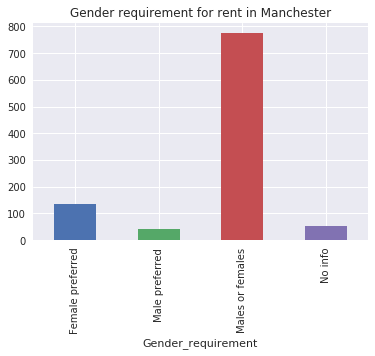

In [44]:
Manchester.gender_preference_analysis('bar')

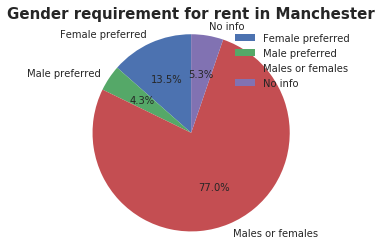

In [45]:
Manchester.gender_preference_analysis('pie')

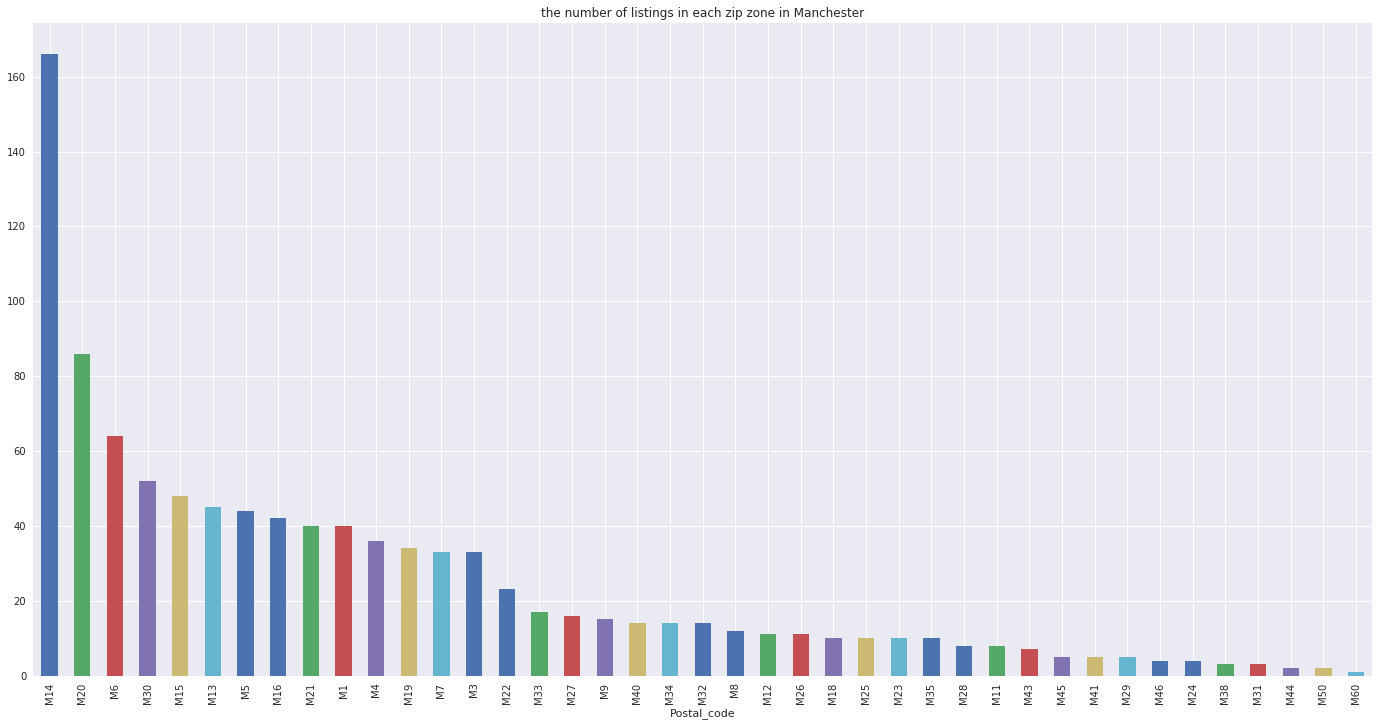

In [46]:
Manchester.size_analysis('bar')

In [58]:
Manchester.size_analysis('heatmap')

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


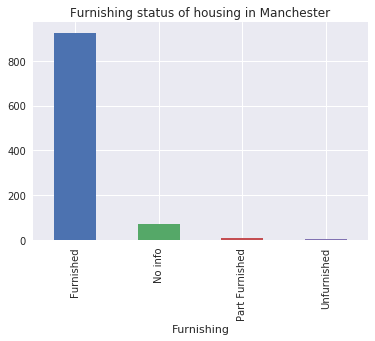

In [51]:
Manchester.furnishing_analysis('bar')

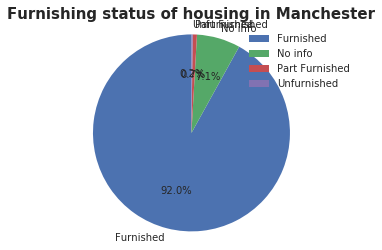

In [52]:
Manchester.furnishing_analysis('pie')

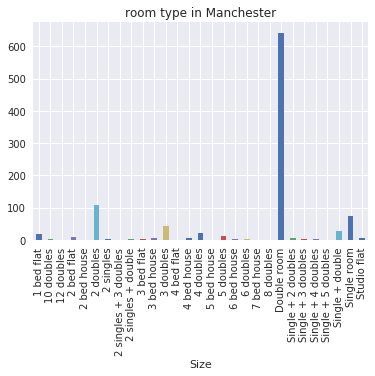

In [53]:
Manchester.room_type_analysis('bar')

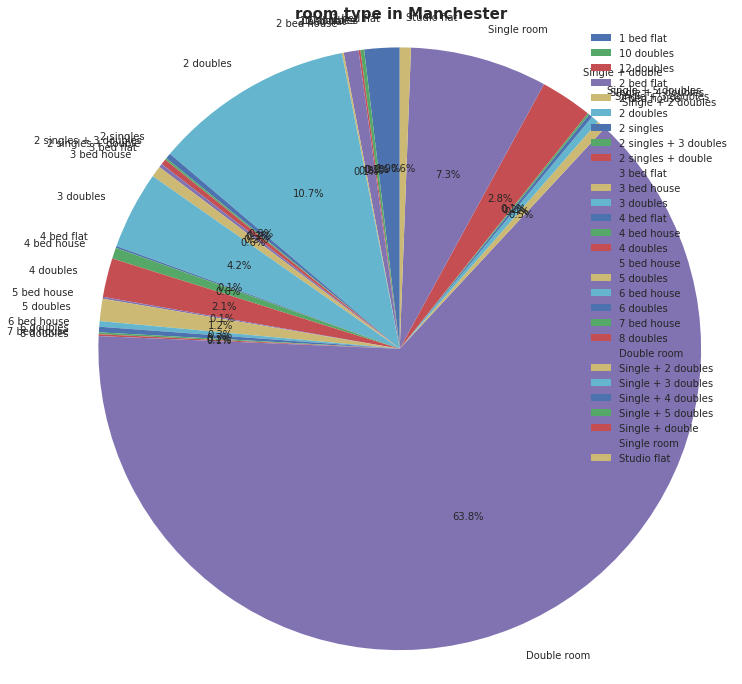

In [54]:
Manchester.room_type_analysis('pie')

In [59]:
Manchester.price_analysis('heatmap')

<h1>Leeds

In [66]:
url_leeds = 'https://www.spareroom.co.uk/flatshare/?search_id=748742143&'
Leeds = rental(url_leeds, 'Leeds')

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


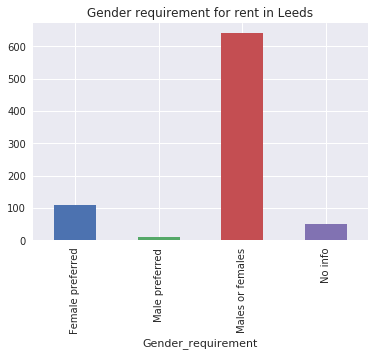

In [14]:
Leeds.gender_preference_analysis('bar')

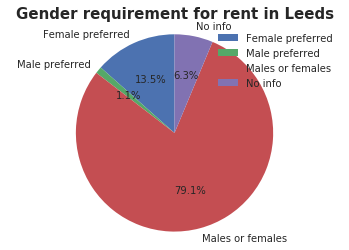

In [15]:
Leeds.gender_preference_analysis('pie')

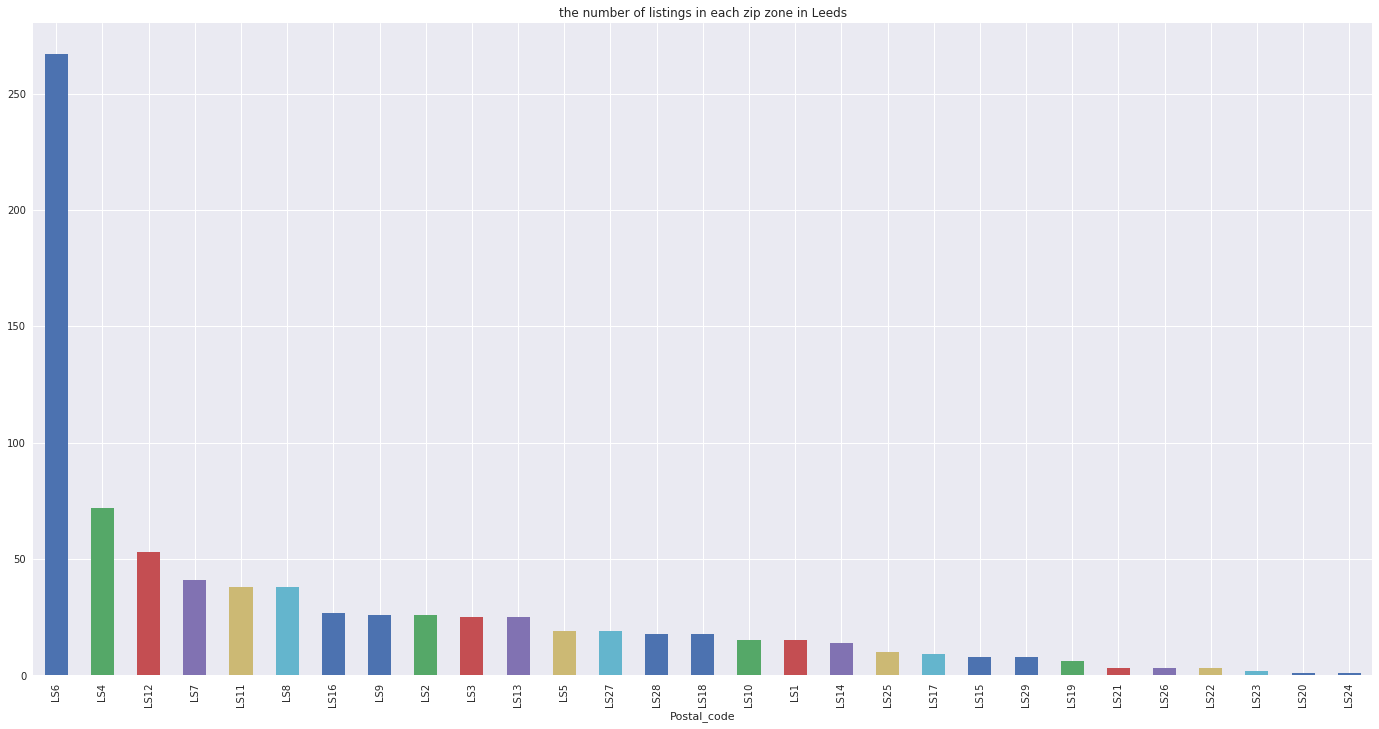

In [16]:
Leeds.size_analysis('bar')

In [18]:
Leeds.size_analysis('heatmap')

/usr/local/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


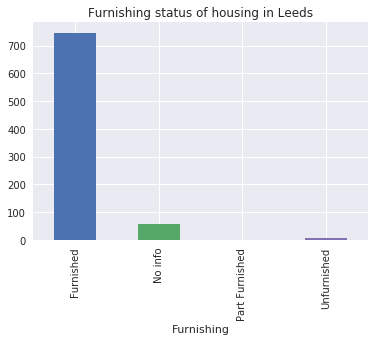

In [19]:
Leeds.furnishing_analysis('bar')

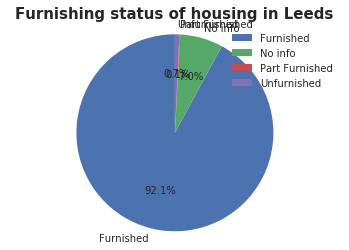

In [20]:
Leeds.furnishing_analysis('pie')

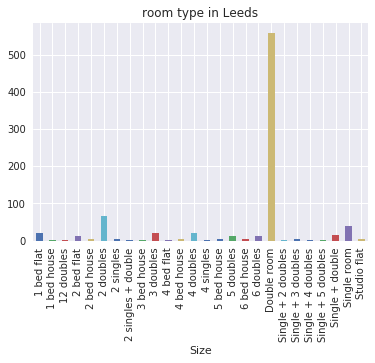

In [21]:
Leeds.room_type_analysis('bar')

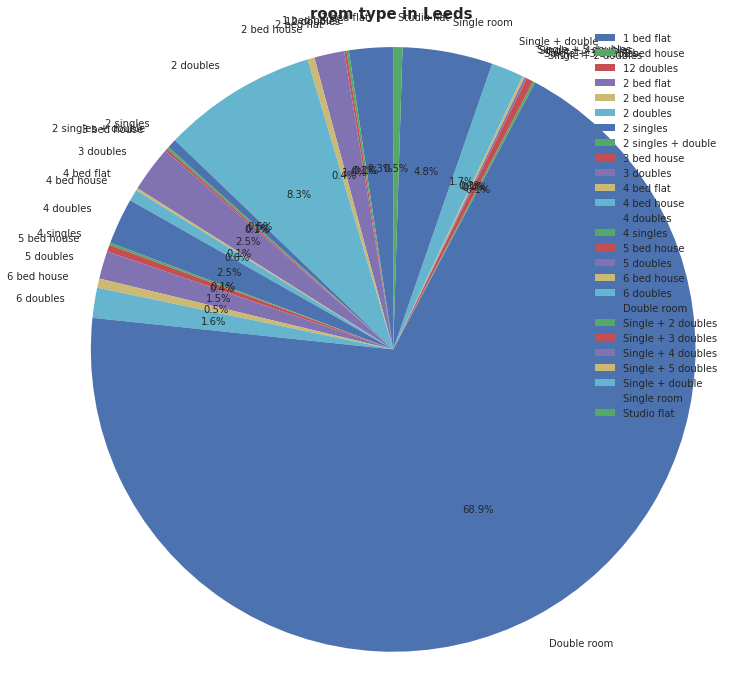

In [22]:
Leeds.room_type_analysis('pie')

In [23]:
Leeds.price_analysis('heatmap')